In [17]:
from properties import POSTGRES_CREDENTIALS
from utils import create_connection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
conn, cursor = create_connection("genius_db")
cursor.execute("select song_id, cluster_id from song_cluster")
song_cluster = pd.DataFrame(cursor.fetchall(), columns =["song_id", "cluster_id"])
cursor.execute("SELECT column_name FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = 'cluster'")
columns = list(map(lambda x: x[0], cursor.fetchall()))
cursor.execute("select * from cluster")
cluster = pd.DataFrame(cursor.fetchall(), columns=columns).set_index("cluster_id")
conn.close()

In [19]:
conn, cursor = create_connection("lfm2b")

# Create a forwarder to the genius DB so that we can easily join tables.
script = f"""
CREATE EXTENSION IF NOT EXISTS postgres_fdw;

DO $$
BEGIN
  IF NOT EXISTS (
    SELECT 1 FROM pg_foreign_server WHERE srvname = 'genius_server'
  ) THEN
    CREATE SERVER genius_server
      FOREIGN DATA WRAPPER postgres_fdw
      OPTIONS (host '{POSTGRES_CREDENTIALS["host"]}', dbname 'genius_db', port '{POSTGRES_CREDENTIALS["port"]}');
  END IF;
END
$$;

DO $$
BEGIN
  IF NOT EXISTS (
    SELECT 1 FROM pg_user_mappings
    WHERE srvname = 'genius_server'
    AND umuser = (SELECT usesysid FROM pg_user WHERE usename = 'postgres')
  ) THEN
    CREATE USER MAPPING FOR postgres
      SERVER genius_server
      OPTIONS (user '{POSTGRES_CREDENTIALS["user"]}', password '{POSTGRES_CREDENTIALS["password"]}');
  END IF;
END
$$;

DO $$
BEGIN
  IF NOT EXISTS (
    SELECT 1 FROM information_schema.tables
    WHERE table_schema = 'public' AND table_name = 'lfm2b_genius'
  ) THEN
    IMPORT FOREIGN SCHEMA public
      LIMIT TO (lfm2b_genius)
      FROM SERVER genius_server
      INTO public;
  END IF;
END
$$;
"""

# assert False, "Warning! This can take 7+ hours if this is the first time running"

cursor.execute(script)
cursor.execute("""
CREATE TABLE IF NOT EXISTS le_joined_tni AS
SELECT * FROM listening_event WHERE false; -- Empty table with correct schema

DO $$
DECLARE
  chunk_size INTEGER := 10000000;
  max_id INTEGER := 50813339; 
  start_id INTEGER := 0;
BEGIN
  IF NOT EXISTS (SELECT 1 FROM le_joined_tni) THEN
    WHILE start_id < max_id LOOP
      RAISE NOTICE 'Processing track_id % to %', start_id, start_id + chunk_size - 1;

      INSERT INTO le_joined_tni
      SELECT le.*
      FROM listening_event le
      JOIN track_non_instrumental tni
        ON le.track_id = tni.track_id
      WHERE le.track_id >= start_id AND le.track_id < start_id + chunk_size;

      start_id := start_id + chunk_size;
    END LOOP;
  END IF;
END
$$ LANGUAGE plpgsql;

CREATE INDEX IF NOT EXISTS le_ni_track_id_idx ON le_joined_tni(track_id);
CREATE INDEX IF NOT EXISTS le_ni_age_at_listen_idx ON le_joined_tni(age_at_listen);
""")

conn.commit()
cursor.execute("select lg.song_id, le.user_id, le.track_id, le.age_at_listen, le.artist_id from listening_event le join lfm2b_genius lg using(track_id)")
le_data = pd.DataFrame(cursor.fetchall(), columns=["song_id", "user_id", "track_id", "age_at_listen", "artist_id"])
conn.close()

In [20]:
listening_events_with_clusters = le_data.merge(song_cluster, on="song_id")

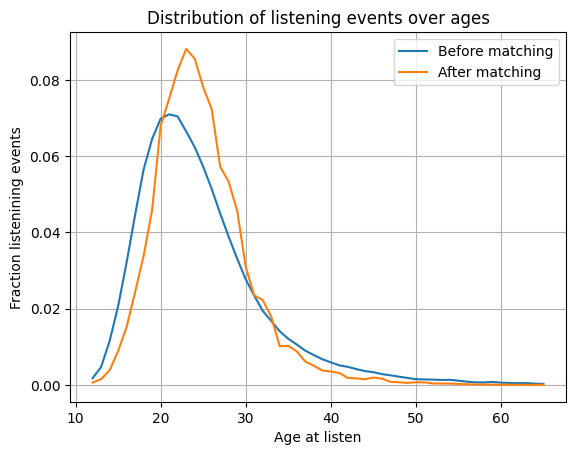

Thrown away 99.87%
Remained 0.13%


In [21]:
conn, cursor = create_connection("lfm2b")
cursor.execute("select age_at_listen, count(track_id) from le_joined_tni group by age_at_listen;")
non_instrumental = pd.DataFrame(cursor.fetchall(), columns=["age_at_listen", "amt_le"]).set_index("age_at_listen")

cursor.execute("select age_at_listen, count(track_id) from listening_event join lfm2b_genius using(track_id) group by age_at_listen")
matches = pd.DataFrame(cursor.fetchall(), columns=["age_at_listen", "amt_le"]).set_index("age_at_listen")
conn.close()

merged = non_instrumental.join(matches, lsuffix="_instrumental", rsuffix="_matched")
merged.div(merged.sum(axis=0), axis=1).rename(
    columns={
        "amt_le_instrumental": "Before matching",
        "amt_le_matched": "After matching",
    }
).plot.line(
    title="Distribution of listening events over ages",
    xlabel="Age at listen",
    ylabel="Fraction listenining events",
)
plt.grid()
plt.show()

totals = merged.sum(axis=0)

a = totals["amt_le_instrumental"]
b = totals["amt_le_matched"]

print(f"Thrown away {abs((b-a)/a):.2%}")
print(f"Remained {b/a:.2%}")

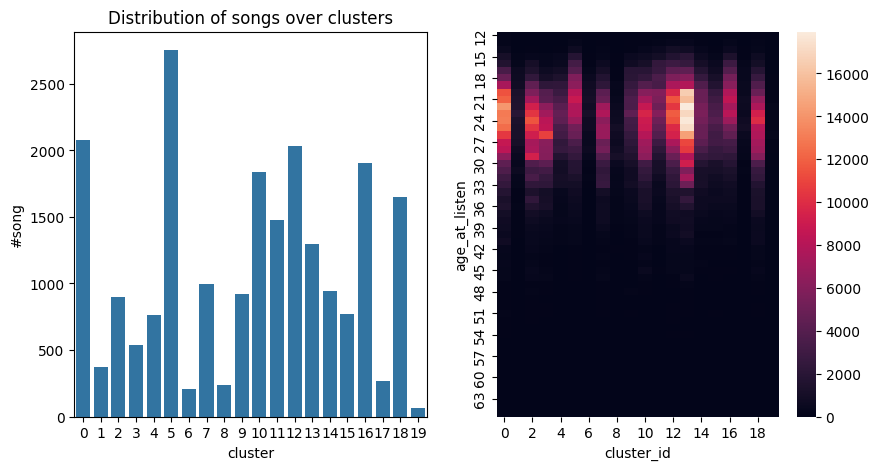

In [22]:
# Let's create a pivot table to see the amount of listening events per age_group and cluster
# https://www.statology.org/pandas-pivot-table-count/
pt = pd.pivot_table(listening_events_with_clusters, values="track_id", index="age_at_listen", columns="cluster_id", aggfunc="count") \
        .fillna(0) \
        .astype(int)

songs_per_cluster = song_cluster.groupby("cluster_id").count().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(figsize=(10,5), nrows=1, ncols=2)

ax1.set_title("Distribution of songs over clusters")
ax1.set_ylabel("#song")
ax1.set_xlabel("cluster")
sns.barplot(songs_per_cluster, x="cluster_id", y="song_id", ax=ax1)
sns.heatmap(pt, ax=ax2)
plt.show()

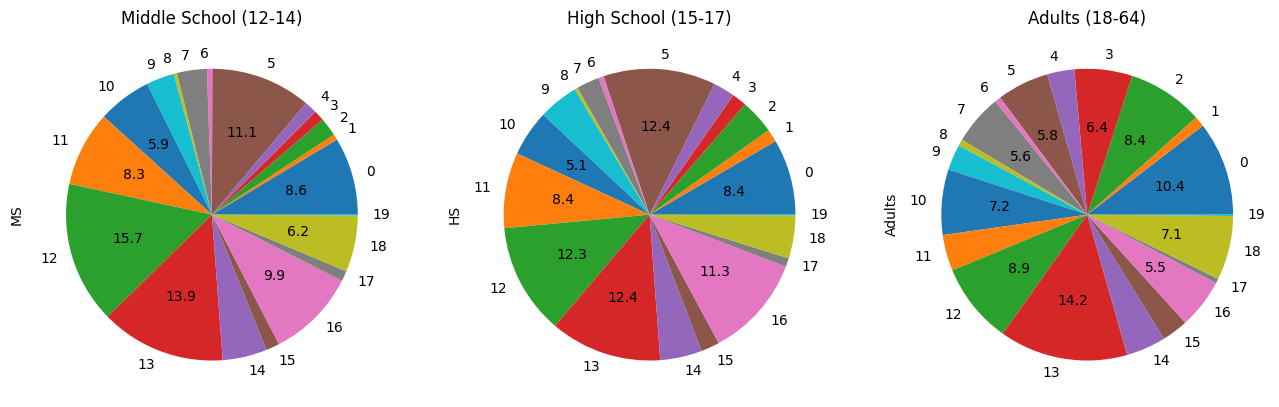

In [23]:
middle_school = pt.loc[12:14].sum()
middle_school.name = "MS"
high_school = pt.loc[15:17].sum()
high_school.name = "HS"
adults = pt.loc[18:].sum()
adults.name="Adults"
children = pt.loc[12:17].sum()
children.name="Children"


fig, (ax1, ax2, ax3) = plt.subplots(figsize = (16,9), ncols=3)

# https://stackoverflow.com/questions/63704956/pie-chart-show-percentage-of-specific-values#63705426 
show_percentages_more_than_5_perc = lambda val : ('%.1f' % val) if val > 5 else ''

middle_school.plot.pie(ax=ax1, title="Middle School (12-14)",autopct=show_percentages_more_than_5_perc)
high_school.plot.pie(ax=ax2, title="High School (15-17)", autopct=show_percentages_more_than_5_perc)
adults.plot.pie(ax=ax3, title="Adults (18-64)", autopct=show_percentages_more_than_5_perc)
plt.show()


le_counts_grouped = pd.concat([children, middle_school, high_school, adults], axis=1)

In [24]:
# Manual calculation 
observed = le_counts_grouped[["MS", "HS", "Adults"]]
observed["total"] = observed.sum(axis='columns')
observed.loc["total"] = observed.sum(axis='index')

# Calculate the expected values under the assumption that the distribution is equal among the three groups
age_group_fractions = observed.loc["total"][["MS", "HS", "Adults"]]/observed.loc["total"]["total"]
expected = pd.DataFrame(
    [
        age_group_fractions["MS"] * observed.loc[0:19]["total"],
        age_group_fractions["HS"] * observed.loc[0:19]["total"],
        age_group_fractions["Adults"] * observed.loc[0:19]["total"]
    ], index=["MS", "HS", "Adults"]
).T

# Calculate the Chi^2 value 
obs = observed.loc[0:19][["MS", "HS", "Adults"]] # Remove the totals
chi_sq_value = ((expected-obs)**2/expected).sum(axis='columns').sum(axis='index')
degrees_of_freedom=(len(obs.columns)-1) * (len(obs.index) -1)
chi_sq_value

# ------------------------------------------------------------------------------------------------------------------------
# Scipy calculation 

from scipy.stats import chi2_contingency
import numpy as np
chi2, p, dof, exp = chi2_contingency(le_counts_grouped[["MS", "HS", "Adults"]])

assert chi_sq_value == chi2
assert degrees_of_freedom == dof
assert np.allclose(expected.to_numpy(), exp, atol=1e-10)
print("MS->HS->Adults")
print(f"\tChi-squared: {chi2}")
print(f"\tDegrees of freedom: {dof}")
print(f"\tp-value: {p}")
print(f"\tsignificant={p<0.05}")

assert p < 0.005, "Result not significant"

print()
# Lets inspect if we take each 2 group combination
for a, b in [("MS", "HS"), ("HS", "Adults"), ("MS", "Adults"), ("Children", "Adults")]:
    _, p, _, _ = chi2_contingency(le_counts_grouped[[a, b]])
    print(f"{a}->{b}: p={p}, significant={p<0.05}")

MS->HS->Adults
	Chi-squared: 23526.525159963207
	Degrees of freedom: 38
	p-value: 0.0
	significant=True

MS->HS: p=5.755530751990348e-66, significant=True
HS->Adults: p=0.0, significant=True
MS->Adults: p=0.0, significant=True
Children->Adults: p=0.0, significant=True


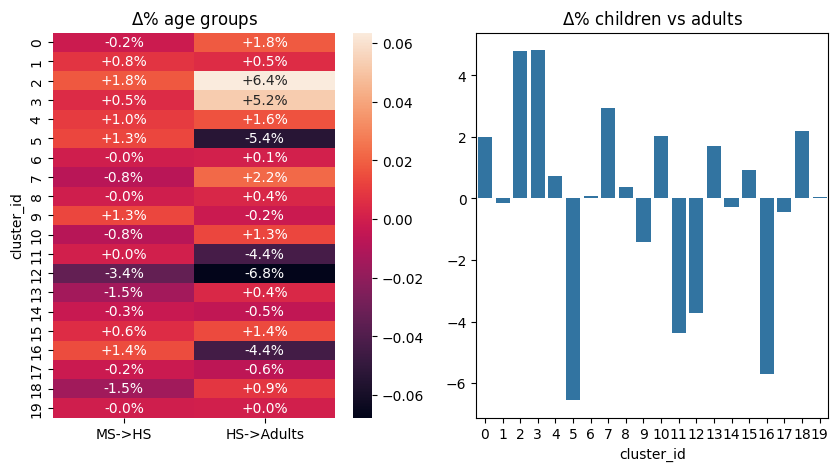

In [25]:
# Let's inspect the percentage point differences per cluster
le_counts_grouped_normalized = le_counts_grouped.div(le_counts_grouped.sum(axis=0))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))

differences = pd.DataFrame(
    [
        le_counts_grouped_normalized["HS"] - le_counts_grouped_normalized["MS"],
        le_counts_grouped_normalized["Adults"] - le_counts_grouped_normalized["MS"],
    ],
    index=["MS->HS", "HS->Adults"]
).T
sns.heatmap(differences, annot=True, fmt="+.1%", ax=ax1)
sns.barplot((le_counts_grouped_normalized["Adults"] - le_counts_grouped_normalized["Children"]) * 100, ax=ax2)

ax1.set_title("$\Delta\%$ age groups")
ax2.set_title("$\Delta\%$ children vs adults")
plt.show()

\begin{tabular}{lrrrrrr}
\toprule
cluster_id & 2 & 3 & 4 & 11 & 12 & 16 \\
\midrule
amt_intro & 0.773955 & 0.841442 & 1.011970 & 1.369244 & 0.391269 & 0.420605 \\
pos_avg_intro & 0.060422 & 0.101834 & 0.127861 & 0.087885 & 0.012272 & 0.002375 \\
pos_std_intro & 0.060462 & 0.090580 & 0.134890 & 0.099826 & 0.000000 & 0.000000 \\
amt_verse & 2.101325 & 2.012552 & 2.438646 & 2.395492 & 0.513367 & 1.561919 \\
pos_avg_verse & 1.946346 & 2.026368 & 2.421472 & 2.022423 & 0.218559 & 1.048501 \\
pos_std_verse & 2.305258 & 2.358551 & 2.456558 & 1.879798 & 0.051577 & 1.066418 \\
amt_pre_chorus & 3.045803 & 1.382953 & 0.064851 & 0.007440 & 0.006083 & 0.001439 \\
pos_avg_pre_chorus & 2.912418 & 1.496410 & 0.096780 & 0.008125 & 0.003665 & 0.001517 \\
pos_std_pre_chorus & 2.874803 & 1.566655 & 0.056451 & 0.004949 & 0.000799 & 0.001276 \\
amt_chorus & 1.786392 & 1.917443 & 0.838692 & 0.024244 & 0.110349 & 0.017767 \\
pos_avg_chorus & 2.150551 & 2.254561 & 0.947605 & 0.050926 & 0.073767 & 0.023115 \\
po

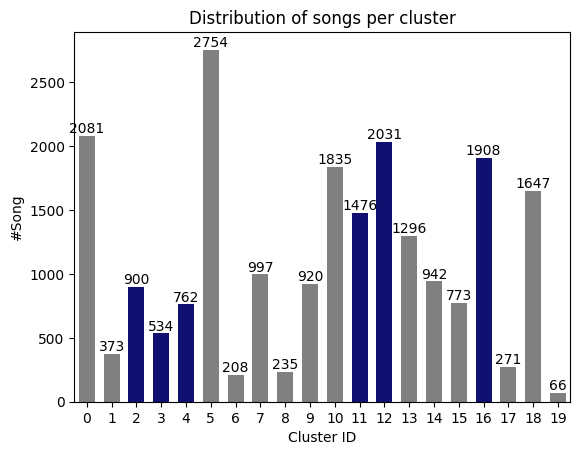

In [ ]:
interesting_clusters = [2,3,4,11,12,16]
df_interesting_clusters = cluster.loc[interesting_clusters].T
print(df_interesting_clusters.to_latex())
#-------------------------------------------------------------------------------
highlight_color = 'navy'
normal_color = 'grey'

colors = [highlight_color if cluster_id in interesting_clusters else normal_color for cluster_id in cluster.index]
ax = sns.barplot(songs_per_cluster,x="cluster_id",y="song_id", hue="cluster_id", legend=False, palette=colors, width=0.8, gap=0.2)

# Show label per bar 
# https://www.geeksforgeeks.org/how-to-show-values-on-seaborn-barplot/
for cont in ax.containers:
    ax.bar_label(cont)


plt.xlabel("Cluster ID")
plt.ylabel("#Song")
plt.title("Distribution of songs per cluster")
plt.show()

In [52]:
df_interesting_clusters

cluster_id,2,3,4,11,12,16
amt_intro,0.773955,0.841442,1.011970,1.369244,0.391269,0.420605
pos_avg_intro,0.060422,0.101834,0.127861,0.087885,0.012272,0.002375
pos_std_intro,0.060462,0.090580,0.134890,0.099826,0.000000,0.000000
amt_verse,2.101325,2.012552,2.438646,2.395492,0.513367,1.561919
pos_avg_verse,1.946346,2.026368,2.421472,2.022423,0.218559,1.048501
pos_std_verse,2.305258,2.358551,2.456558,1.879798,0.051577,1.066418
amt_pre_chorus,3.045803,1.382953,0.064851,0.007440,0.006083,0.001439
pos_avg_pre_chorus,2.912418,1.496410,0.096780,0.008125,0.003665,0.001517
pos_std_pre_chorus,2.874803,1.566655,0.056451,0.004949,0.000799,0.001276
amt_chorus,1.786392,1.917443,0.838692,0.024244,0.110349,0.017767


<Figure size 1600x1600 with 0 Axes>

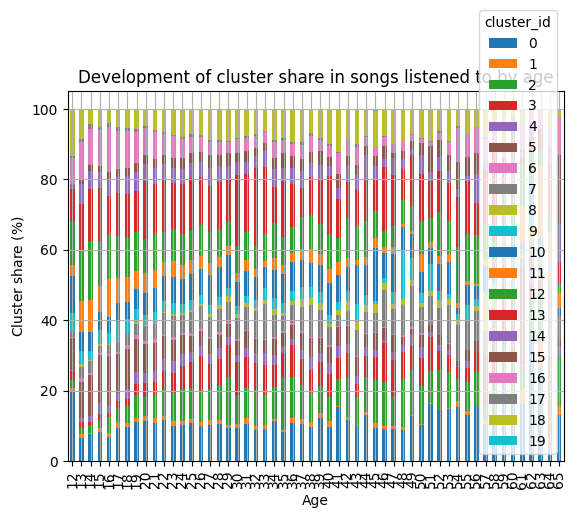

In [27]:
shown_clusters=range(20) # Show all clusters
# shown_clusters = [1,3,5,7]

shown_ages = range(12, 66) # Show all ages
# shown_ages = range(12, 18)

fig = plt.figure(figsize=(16,16))

pt_normalized = pt.div(pt.sum(axis=1), axis=0)
(pt_normalized * 100).loc[shown_ages][shown_clusters].plot.bar(
    stacked=True,
    title="Development of cluster share in songs listened to by age",
    xlabel="Age",
    ylabel="Cluster share ($\%$)",
)
plt.grid()
plt.show()